# Minimization with MinKit
The main purpose of the MinKit package is to do minimizations of PDFs to data sets, finding the set of parameter values that reproduce better the data. The user must be aware about the type of PDF is trying to fit, and select a proper minimization cuantity (FCN) accordingly. For example, if we are dealing with an unbinned dataset, we need an FCN defined for binned data sets. The same stands for extended and non-extended PDFs. The user must know whether an unbinned extended maximum likelihood FCN is needed or not. To give an idea of how the minimization is done with MinKit, let's create a simple model, generate some data, and fit it.

FCN = 28448.875507188248 
 TOTAL NCALL = 26 
 NCALLS = 26 
 
 
 EDM = 1.5108616984208242e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,c,14.9986,0.010035,,,10,20,No
1,s,1.00349,0.00709615,,,0.1,2,No


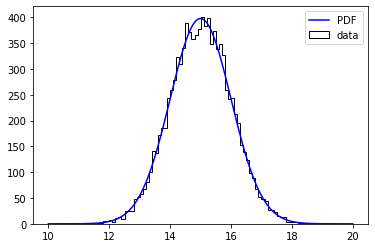

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import minkit

# Build the PDF
x = minkit.Parameter('x', bounds=(10, 20))
c = minkit.Parameter('c', 15, bounds=(10, 20))
s = minkit.Parameter('s', 1, bounds=(0.1, 2))

g = minkit.Gaussian('g', x, c, s)

# Keep the initial values
initials = g.get_values()

# Generate data and do the fit
data = g.generate(10000)

with minkit.minimizer('uml', g, data) as minimizer:
    minimizer.migrad()
    
# Plot the results
values, edges = minkit.data_plotting_arrays(data, bins=100)

centers = 0.5 * (edges[1:] + edges[:-1])

plt.hist(centers, bins=edges, weights=values, histtype='step', color='k', label='data');

gx, pdf_values = minkit.pdf_plotting_arrays(g, values, edges)
plt.plot(gx, pdf_values, color='blue', label='PDF')
plt.legend();

# Reset values
g.set_values(**initials)

Note that we have called *minkit.minimizer* in order to create a context and do the minimization. The first argument is the FCN to use, an unbinned maximum likelihood in this case. It is very important that we do not change the properties of the PDF inside the *with* statement. This is because the PDF has enabled a cache. This means that, if the parameters have been set to constant, the evaluation of the PDF over the data values might have been kept in the cache, to reduce the execution time.

Let's create a more complex model, adding a background-like contribution, using an exponential.

FCN = 41924.57136177349 
 TOTAL NCALL = 74 
 NCALLS = 74 
 
 
 EDM = 0.00010774089852706737 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,y,0.507504,0.00965615,,,0,1,No
1,c,15.008,0.021228,,,10,20,No
2,s,1.03644,0.0210311,,,0.1,2,No
3,k,-0.101637,0.00567342,,,-1,0,No


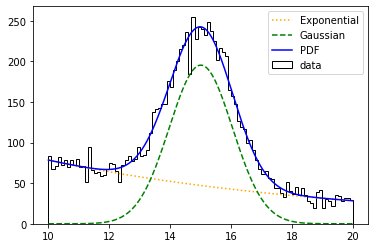

In [2]:
# Make the exponential PDF
k = minkit.Parameter('k', -0.1, bounds=(-1, 0))

e = minkit.Exponential('e', x, k)

# Add the two PDFs
y = minkit.Parameter('y', 0.5, bounds=(0, 1))

pdf = minkit.AddPDFs.two_components('pdf', g, e, y)

data = pdf.generate(10000)

# Keep the initial values
initials = pdf.get_values()

# Minimize the PDF
with minkit.minimizer('uml', pdf, data) as minimizer:
    minimizer.migrad()

values, edges = minkit.data_plotting_arrays(data, bins=100)

centers = 0.5 * (edges[1:] + edges[:-1])

plt.hist(centers, bins=edges, weights=values, histtype='step', color='k', label='data');

pdf_centers, pdf_values = minkit.pdf_plotting_arrays(pdf, values, edges)
_, g_values = minkit.pdf_plotting_arrays(pdf, values, edges, component='g')
_, e_values = minkit.pdf_plotting_arrays(pdf, values, edges, component='e')

plt.plot(pdf_centers, e_values, color='orange', linestyle=':', label='Exponential')
plt.plot(pdf_centers, g_values, color='green', linestyle='--', label='Gaussian')
plt.plot(pdf_centers, pdf_values, color='blue', label='PDF')

plt.legend();

# Reset values
pdf.set_values(**initials)

Let's now assume we want to know the two yields of the PDFs. To do this we need to modify the model, and do and use an extended likelihood during the minimization.

FCN = -122328.04540489317 
 TOTAL NCALL = 127 
 NCALLS = 127 
 
 
 EDM = 1.3031954399796164e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,ng,5033.43,106.627,,,0,10000,No
1,ne,4966.6,106.291,,,0,10000,No
2,c,14.9731,0.0207883,,,10,20,No
3,s,1.01474,0.0201699,,,0.1,2,No
4,k,-0.0979807,0.00555692,,,-1,0,No


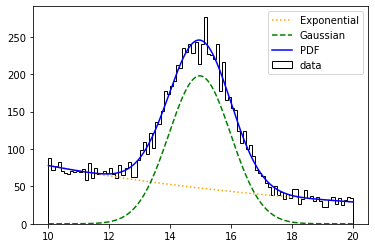

In [3]:
# Build the extended PDF
ng = minkit.Parameter('ng', 5000, bounds=(0, 10000))
ne = minkit.Parameter('ne', 5000, bounds=(0, 10000))

pdf = minkit.AddPDFs.two_components('pdf', g, e, ng, ne)

initials = pdf.get_values()

# Generate and fit
data = pdf.generate(int(ng.value + ne.value))

ng.value = 6000 # vary the yields to flee from the minimum
ne.value = len(data) - ng.value

with minkit.minimizer('ueml', pdf, data) as minimizer:
    minimizer.migrad()

values, edges = minkit.data_plotting_arrays(data, bins=100)

centers = 0.5 * (edges[1:] + edges[:-1])

plt.hist(centers, bins=edges, weights=values, histtype='step', color='k', label='data');

pdf_centers, pdf_values = minkit.pdf_plotting_arrays(pdf, values, edges)
_, g_values = minkit.pdf_plotting_arrays(pdf, values, edges, component='g')
_, e_values = minkit.pdf_plotting_arrays(pdf, values, edges, component='e')

plt.plot(pdf_centers, e_values, color='orange', linestyle=':', label='Exponential')
plt.plot(pdf_centers, g_values, color='green', linestyle='--', label='Gaussian')
plt.plot(pdf_centers, pdf_values, color='blue', label='PDF')

plt.legend();

# Reset the values
pdf.set_values(**initials)

Note that we have specified the *ueml* (unbinned extended maximum likelihood) FCN. If we set it to *uml*, we would get wrong values. Let's now see what happens with binned data sets. In this case, we will use the *bml* FCN.

FCN = 90.13606781284405 
 TOTAL NCALL = 98 
 NCALLS = 98 
 
 
 EDM = 2.7026695375105786e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,ng,5030.71,7427.35,,,0,10000,No
1,ne,4969.54,7403.42,,,0,10000,No
2,c,14.9736,0.0207842,,,10,20,No
3,s,1.01358,0.020229,,,0.1,2,No
4,k,-0.0979249,0.00556058,,,-1,0,No


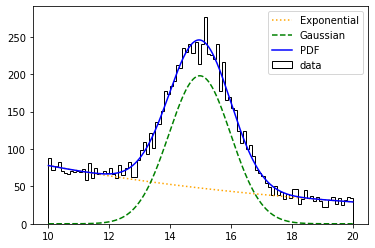

In [4]:
import numpy as np

values, edges = np.histogram(data['x'].as_ndarray(), bins=100, range=x.bounds)

binned_data = minkit.BinnedDataSet.from_ndarray(edges, x, values)

with minkit.minimizer('bml', pdf, binned_data) as minimizer:
    minimizer.migrad()

values, edges = minkit.data_plotting_arrays(data, bins=100)

centers = 0.5 * (edges[1:] + edges[:-1])

plt.hist(centers, bins=edges, weights=values, histtype='step', color='k', label='data');

pdf_centers, pdf_values = minkit.pdf_plotting_arrays(pdf, values, edges)
_, g_values = minkit.pdf_plotting_arrays(pdf, values, edges, component='g')
_, e_values = minkit.pdf_plotting_arrays(pdf, values, edges, component='e')

plt.plot(pdf_centers, e_values, color='orange', linestyle=':', label='Exponential')
plt.plot(pdf_centers, g_values, color='green', linestyle='--', label='Gaussian')
plt.plot(pdf_centers, pdf_values, color='blue', label='PDF')

plt.legend();

# Reset the values
pdf.set_values(**initials)

Similarly, with the FCN *chi2* we would be doing a fit to the chi-square, that is, we would be assuming that the input values, instead of following a Poisson distribution, they follow a Gaussian.